TODO:
1) handle missing values
2) check correlation cat with target
3) feature engineering - divide cabin, passenger_id, check last name , age_bin 
4) check outliers 
5) transformer for numerical (probably e)
6) coding categories cols
7) try classic - logictic_regression, random forest, cat_boost 
8) try more sophisticated - deep learning 

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, f1_score

# Read data

In [3]:
data = '../data/spaceship-titanic/train.csv'

In [4]:
df = pd.read_csv(data)

# EDA

In [5]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


<Axes: xlabel='Transported'>

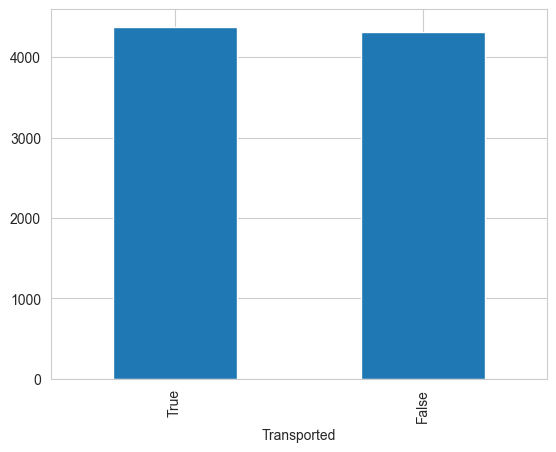

In [6]:
df['Transported'].value_counts().plot(kind='bar')

In [7]:
df.shape

(8693, 14)

In [8]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [10]:
df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [11]:
cat_cols = df.select_dtypes(include='object').columns.tolist()

In [12]:
num_cols = df.select_dtypes(include='float64').columns.tolist()

In [13]:
bill_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [14]:
num_cols

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [15]:
cat_cols

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'VIP',
 'Name']

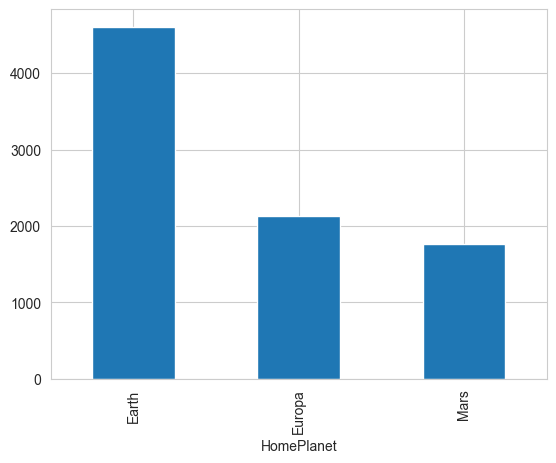

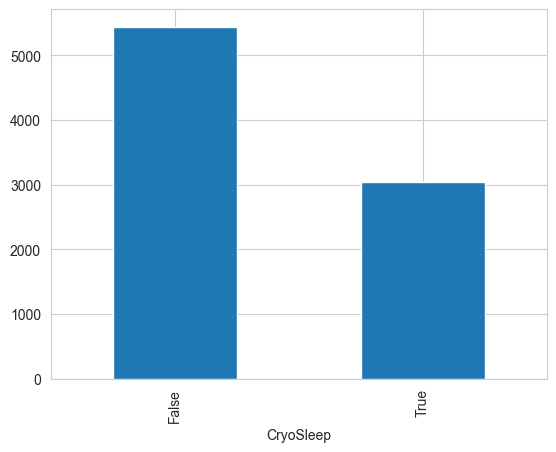

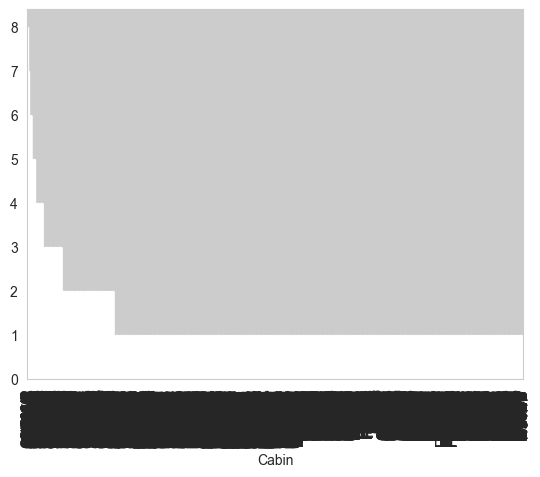

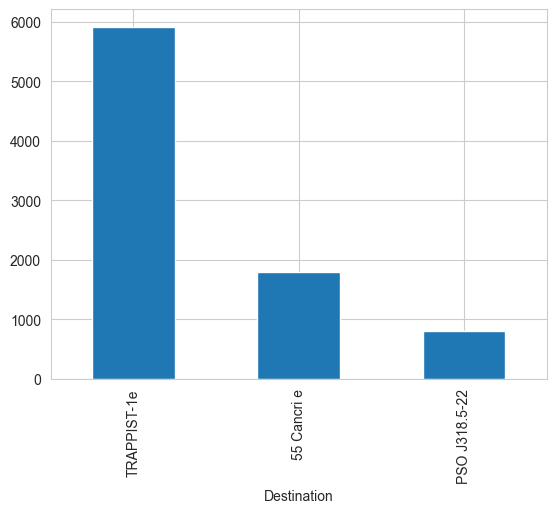

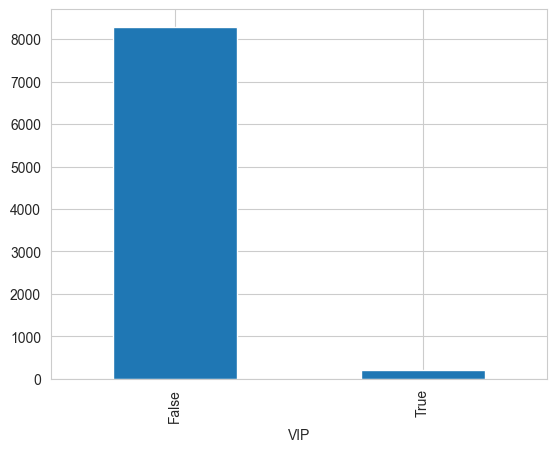

In [16]:
for col in cat_cols[1:-1]:
    df[col].value_counts().plot(kind='bar')
    plt.show()

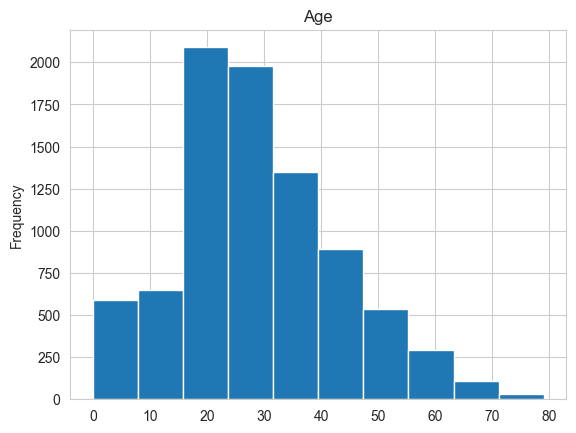

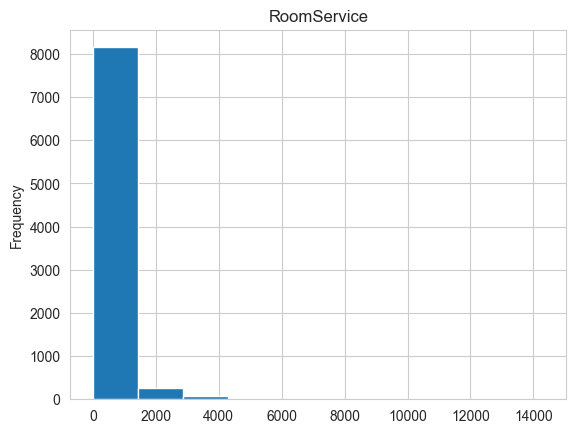

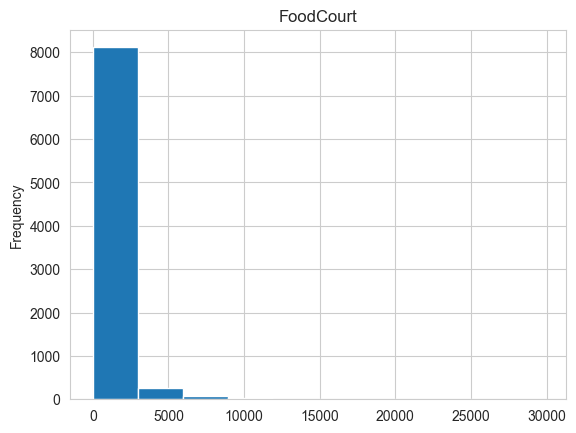

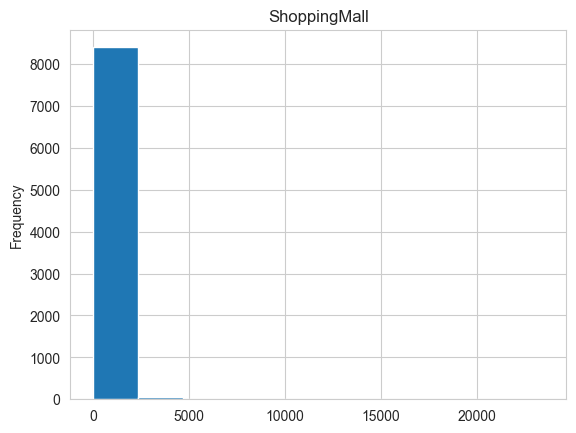

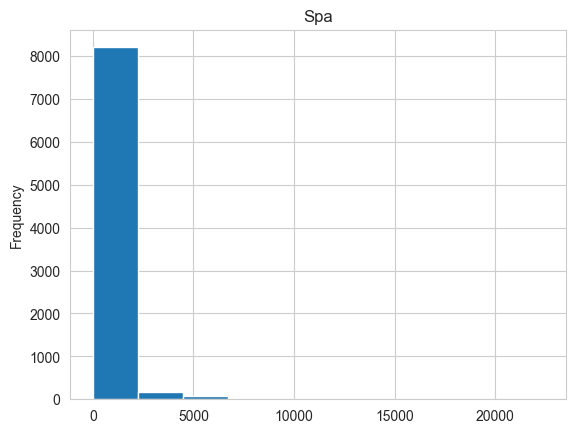

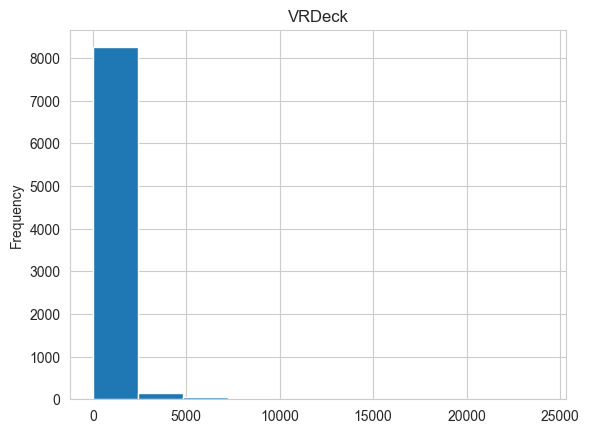

In [17]:
for col in num_cols:
    df[col].plot(kind='hist')
    plt.title(col)
    plt.show()

In [18]:
df['target'] = df.apply(lambda row: 0 if row['Transported'] == False else 1, axis=1)

<Axes: xlabel='target'>

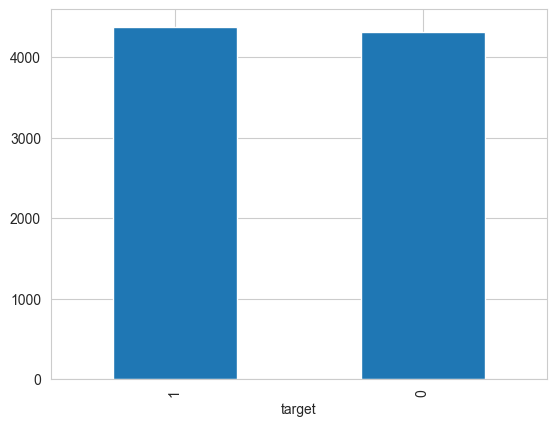

In [19]:
df['target'].value_counts().plot(kind='bar')

In [20]:
corr = df[num_cols + ['target']].corr()

<Axes: >

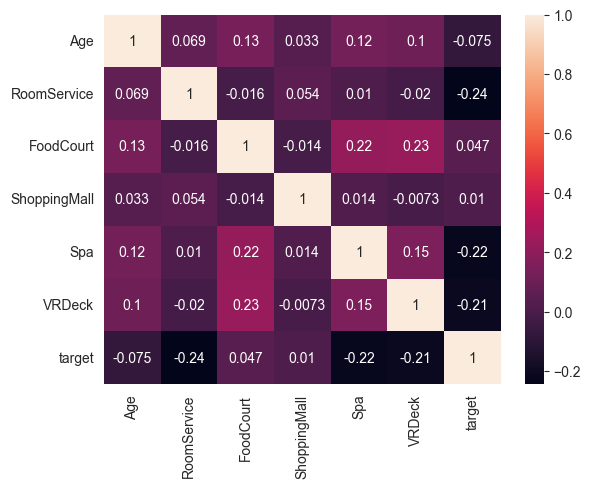

In [21]:
sns.heatmap(corr, annot=True)

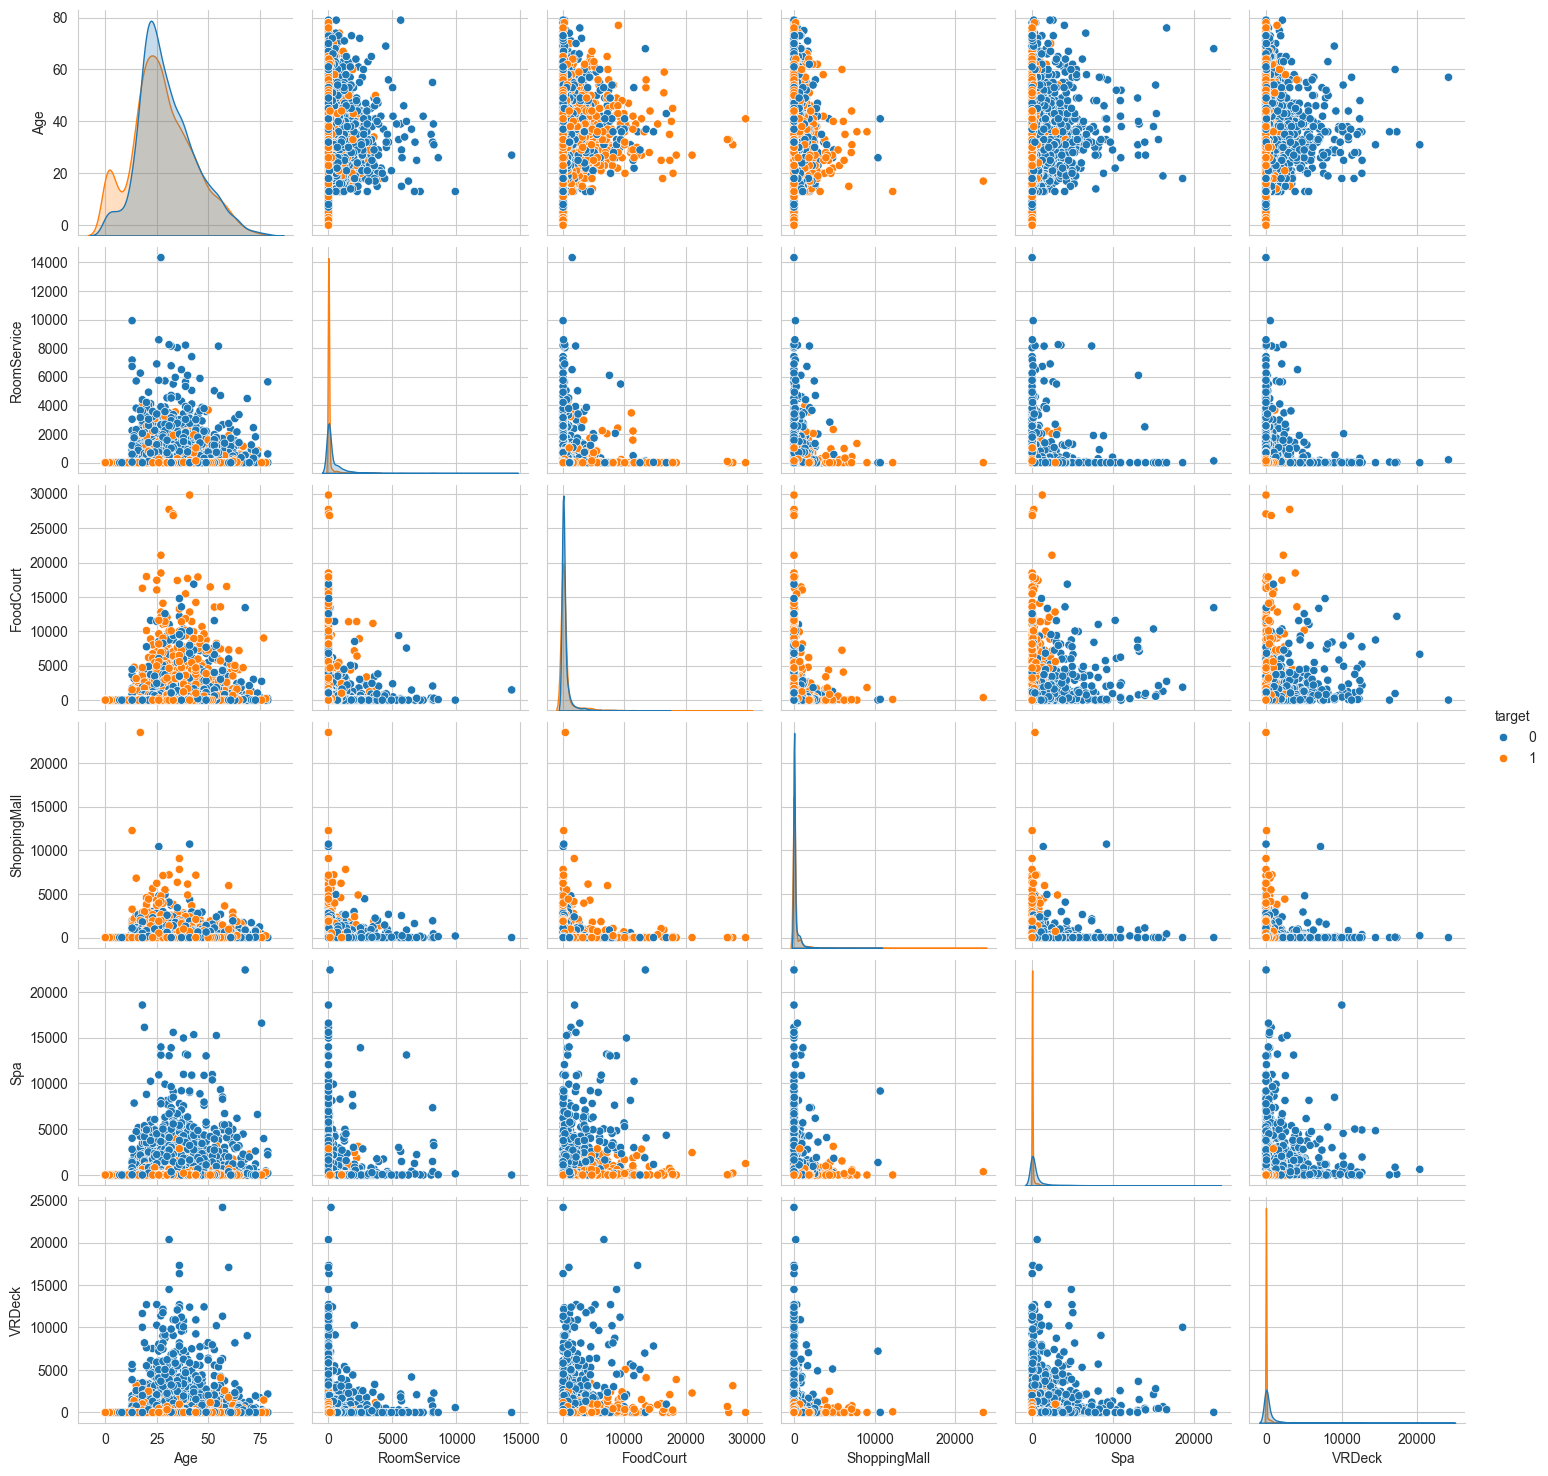

In [22]:
sns.pairplot(df[num_cols + ['target']], hue='target')

# Feature Engineering

In [23]:
df['group'] = df.apply(lambda row: row['PassengerId'].split('_')[0], axis=1)
df['num_group'] = df.apply(lambda row: row['PassengerId'].split('_')[1], axis=1)

In [24]:
df['deck'] = df.apply(lambda row: row['Cabin'].split('/')[0] if pd.notna(row['Cabin']) else row['Cabin'] , axis=1)
df['num_cabin'] = df.apply(lambda row: row['Cabin'].split('/')[1] if pd.notna(row['Cabin']) else row['Cabin'], axis=1)
df['side_cabin'] = df.apply(lambda row: row['Cabin'].split('/')[2] if pd.notna(row['Cabin']) else row['Cabin'], axis=1)

In [25]:
df['last_name'] = df.apply(lambda row: row['Name'].split()[1] if pd.notna(row['Name']) else row['Name'], axis=1)

# Handling missing values

In [26]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,Transported,target,group,num_group,deck,num_cabin,side_cabin,last_name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,0.0,Maham Ofracculy,False,0,0001,01,B,0,P,Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,44.0,Juanna Vines,True,1,0002,01,F,0,S,Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,49.0,Altark Susent,False,0,0003,01,A,0,S,Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,193.0,Solam Susent,False,0,0003,02,A,0,S,Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,2.0,Willy Santantines,True,1,0004,01,F,1,S,Santantines


In [27]:
temp = df.groupby('group').size().reset_index(name='group_size')

In [28]:
temp['group'] = temp['group'].astype('object')

In [29]:
df = df.merge(temp, how='left', on='group')

In [31]:
temp['group_size'].value_counts()

group_size
1    4805
2     841
3     340
4     103
5      53
7      33
6      29
8      13
Name: count, dtype: int64

In [32]:
temp[temp['group_size'] > 4]

,group,group_size
16,0020,6
143,0220,7
144,0221,7
247,0378,7
334,0504,6
...,...,...
6073,9069,5
6077,9074,6
6084,9081,8
6132,9157,7


In [33]:
df[df['group'] == '0220']

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name,Transported,target,group,num_group,deck,num_cabin,side_cabin,last_name,group_size
196,0220_01,Earth,True,G/37/P,TRAPPIST-1e,2.0,False,0.0,0.0,0.0,...,Tyle Wilsoney,True,1,0220,01,G,37,P,Wilsoney,7
197,0220_02,Earth,False,G/37/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,...,Wena Wilsoney,True,1,0220,02,G,37,P,Wilsoney,7
198,0220_03,Earth,True,G/37/P,TRAPPIST-1e,13.0,False,0.0,0.0,0.0,...,Branca Wilsoney,False,0,0220,03,G,37,P,Wilsoney,7
199,0220_04,Earth,False,E/10/P,TRAPPIST-1e,25.0,False,122.0,84.0,NaN,...,Dont Wilsoney,False,0,0220,04,E,10,P,Wilsoney,7
200,0220_05,Earth,False,F/48/P,TRAPPIST-1e,16.0,False,0.0,3.0,0.0,...,Velyne Wilsoney,False,0,0220,05,F,48,P,Wilsoney,7
201,0220_06,Earth,False,G/37/P,55 Cancri e,1.0,False,0.0,0.0,0.0,...,Weney Wilsoney,False,0,0220,06,G,37,P,Wilsoney,7
202,0220_07,Earth,True,G/37/P,TRAPPIST-1e,15.0,False,0.0,0.0,0.0,...,Guye Wilsoney,True,1,0220,07,G,37,P,Wilsoney,7


In [34]:
df[df['group'] == '0571']

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name,Transported,target,group,num_group,deck,num_cabin,side_cabin,last_name,group_size
537,0571_01,Europa,True,C/21/P,55 Cancri e,22.0,False,0.0,0.0,0.0,...,Branev Ousious,True,1,0571,01,C,21,P,Ousious,7
538,0571_02,Europa,True,C/21/P,TRAPPIST-1e,19.0,False,0.0,0.0,0.0,...,Alchium Ousious,False,0,0571,02,C,21,P,Ousious,7
539,0571_03,Europa,True,C/21/P,TRAPPIST-1e,42.0,False,0.0,0.0,0.0,...,Bahoton Ousious,True,1,0571,03,C,21,P,Ousious,7
540,0571_04,Europa,True,C/21/P,NaN,30.0,False,0.0,0.0,0.0,...,Izark Hednigic,True,1,0571,04,C,21,P,Hednigic,7
541,0571_05,Europa,True,C/21/P,55 Cancri e,16.0,False,0.0,0.0,0.0,...,Polam Ousious,True,1,0571,05,C,21,P,Ousious,7
542,0571_06,Europa,False,C/21/P,TRAPPIST-1e,55.0,False,0.0,1542.0,0.0,...,Hasich Ousious,False,0,0571,06,C,21,P,Ousious,7
543,0571_07,Europa,True,C/21/P,TRAPPIST-1e,55.0,False,0.0,0.0,0.0,...,Isoton Ousious,True,1,0571,07,C,21,P,Ousious,7


In [35]:
df[df['group'] == '0714']

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name,Transported,target,group,num_group,deck,num_cabin,side_cabin,last_name,group_size
684,0714_01,Earth,True,G/109/P,PSO J318.5-22,38.0,False,0.0,0.0,0.0,...,Erie Rilley,True,1,0714,01,G,109,P,Rilley,7
685,0714_02,Earth,False,G/109/P,TRAPPIST-1e,1.0,False,0.0,0.0,0.0,...,Claine Rilley,False,0,0714,02,G,109,P,Rilley,7
686,0714_03,Earth,False,G/109/P,NaN,12.0,False,0.0,0.0,NaN,...,Sony Rilley,True,1,0714,03,G,109,P,Rilley,7
687,0714_04,Earth,True,G/109/P,PSO J318.5-22,2.0,False,0.0,0.0,0.0,...,Charry Rilley,False,0,0714,04,G,109,P,Rilley,7
688,0714_05,Earth,True,G/109/P,PSO J318.5-22,25.0,False,0.0,0.0,0.0,...,Jeanny Rilley,False,0,0714,05,G,109,P,Rilley,7
689,0714_06,Earth,True,G/109/P,55 Cancri e,1.0,False,0.0,0.0,0.0,...,Man Rilley,True,1,0714,06,G,109,P,Rilley,7
690,0714_07,Earth,True,G/109/P,55 Cancri e,0.0,False,0.0,0.0,0.0,...,Brene Rilley,True,1,0714,07,G,109,P,Rilley,7


In [36]:
df[df['group'] == '1709']

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name,Transported,target,group,num_group,deck,num_cabin,side_cabin,last_name,group_size
1608,1709_01,Mars,False,F/326/S,TRAPPIST-1e,23.0,False,31.0,0.0,1247.0,...,Jurbet Minen,False,0,1709,01,F,326,S,Minen,7
1609,1709_02,Mars,False,D/61/S,TRAPPIST-1e,23.0,False,2210.0,0.0,89.0,...,Bet Minen,True,1,1709,02,D,61,S,Minen,7
1610,1709_03,Mars,False,NaN,TRAPPIST-1e,35.0,False,1313.0,0.0,24.0,...,Bleark Minen,False,0,1709,03,NaN,NaN,NaN,Minen,7
1611,1709_04,Mars,False,E/127/S,TRAPPIST-1e,17.0,False,1744.0,0.0,136.0,...,Donut Minen,False,0,1709,04,E,127,S,Minen,7
1612,1709_05,Mars,True,F/326/S,TRAPPIST-1e,26.0,False,0.0,0.0,0.0,...,Fams Minen,True,1,1709,05,F,326,S,Minen,7
1613,1709_06,Mars,False,D/61/S,TRAPPIST-1e,15.0,False,1554.0,0.0,646.0,...,Tyog Minen,False,0,1709,06,D,61,S,Minen,7
1614,1709_07,Mars,False,F/326/S,TRAPPIST-1e,19.0,False,285.0,54.0,1246.0,...,Cocowl Minen,False,0,1709,07,F,326,S,Minen,7


In [37]:
df[df['CryoSleep'].isna()]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name,Transported,target,group,num_group,deck,num_cabin,side_cabin,last_name,group_size
92,0099_02,Earth,NaN,G/12/P,TRAPPIST-1e,2.0,False,0.0,0.0,0.0,...,Thewis Connelson,True,1,0099,02,G,12,P,Connelson,2
98,0105_01,Earth,NaN,F/21/P,TRAPPIST-1e,27.0,False,0.0,0.0,570.0,...,Carry Cleachrand,False,0,0105,01,F,21,P,Cleachrand,1
104,0110_02,Europa,NaN,B/5/P,TRAPPIST-1e,40.0,False,0.0,331.0,0.0,...,Aldeba Bootious,False,0,0110,02,B,5,P,Bootious,4
111,0115_01,Mars,NaN,F/24/P,TRAPPIST-1e,26.0,False,0.0,0.0,0.0,...,Rohs Pead,True,1,0115,01,F,24,P,Pead,1
152,0173_01,Earth,NaN,E/11/S,TRAPPIST-1e,58.0,False,0.0,985.0,0.0,...,Hilip Grifford,True,1,0173,01,E,11,S,Grifford,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8620,9197_01,Europa,NaN,C/308/P,55 Cancri e,44.0,False,0.0,0.0,0.0,...,Bellus Platch,True,1,9197,01,C,308,P,Platch,4
8651,9227_05,Earth,NaN,G/1498/P,TRAPPIST-1e,8.0,False,0.0,0.0,0.0,...,Hard Hinglendez,False,0,9227,05,G,1498,P,Hinglendez,5
8664,9246_01,Earth,NaN,G/1490/S,TRAPPIST-1e,32.0,False,0.0,0.0,0.0,...,NaN,True,1,9246,01,G,1490,S,NaN,1
8675,9259_01,Earth,NaN,F/1893/P,TRAPPIST-1e,44.0,False,1030.0,1015.0,0.0,...,Annah Gilleyons,True,1,9259,01,F,1893,P,Gilleyons,1


In [38]:
df[(df['CryoSleep'] == True) & (df[bill_cols].gt(0).any(axis=1))]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name,Transported,target,group,num_group,deck,num_cabin,side_cabin,last_name,group_size


In [39]:
df[(df['CryoSleep'] == True) & (df[bill_cols].isna().any(axis=1))][bill_cols].fillna(0.0, inplace=True)

In [40]:
filtered_rows = (df['CryoSleep'] == True) & (df[bill_cols].isna().any(axis=1))

imput 0 to bill cols when person is in CryoSleep (they are confined to their cabins)

In [41]:
df.loc[filtered_rows, bill_cols] = df.loc[filtered_rows, bill_cols].fillna(0.0)

In [42]:
df[(df['CryoSleep'] == False) & (df[bill_cols].isna().any(axis=1))]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name,Transported,target,group,num_group,deck,num_cabin,side_cabin,last_name,group_size
16,0014_01,Mars,False,F/3/P,55 Cancri e,27.0,False,1286.0,122.0,NaN,...,Flats Eccle,False,0,0014,01,F,3,P,Eccle,1
35,0031_03,Mars,False,F/9/P,TRAPPIST-1e,20.0,False,NaN,0.0,1750.0,...,Dontch Datie,True,1,0031,03,F,9,P,Datie,3
48,0050_01,Earth,False,E/1/S,55 Cancri e,35.0,False,790.0,0.0,0.0,...,Sony Lancis,False,0,0050,01,E,1,S,Lancis,1
95,0103_01,Earth,False,F/24/S,TRAPPIST-1e,24.0,False,0.0,NaN,0.0,...,Arlen Mclainez,True,1,0103,01,F,24,S,Mclainez,3
132,0141_01,Mars,False,F/30/P,TRAPPIST-1e,31.0,False,NaN,0.0,97.0,...,Pyrohs Harte,False,0,0141,01,F,30,P,Harte,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8611,9192_01,Earth,False,F/1880/P,PSO J318.5-22,24.0,False,NaN,599.0,NaN,...,Norahe Drakeekss,True,1,9192,01,F,1880,P,Drakeekss,1
8623,9197_04,Europa,False,C/308/P,55 Cancri e,30.0,False,1569.0,NaN,0.0,...,Phecca Platch,False,0,9197,04,C,308,P,Platch,4
8633,9211_01,Earth,False,G/1486/S,TRAPPIST-1e,60.0,False,0.0,8.0,NaN,...,Stendy Steelerettt,False,0,9211,01,G,1486,S,Steelerettt,1
8641,9220_03,Earth,False,F/1886/P,PSO J318.5-22,22.0,False,623.0,0.0,NaN,...,Kennie Barrilloney,True,1,9220,03,F,1886,P,Barrilloney,3


## Check how to fill this with number

In [43]:
temp_2 = df[(df['CryoSleep'] == False) &  (df[bill_cols].gt(0) | df[bill_cols].isna()).all(axis=1)]

In [44]:
temp_2[temp_2[bill_cols].isna().any(axis=1)]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name,Transported,target,group,num_group,deck,num_cabin,side_cabin,last_name,group_size
385,0427_01,Europa,False,E/26/P,TRAPPIST-1e,31.0,False,417.0,NaN,7185.0,...,Algor Efulows,True,1,0427,01,E,26,P,Efulows,1
401,0439_01,Europa,False,C/13/P,55 Cancri e,34.0,False,NaN,5637.0,45.0,...,Izarino Unciate,False,0,0439,01,C,13,P,Unciate,1
545,0573_01,Earth,False,F/117/P,TRAPPIST-1e,NaN,False,14.0,809.0,25.0,...,Deandy Dickley,False,0,0573,01,F,117,P,Dickley,1
583,0607_02,Europa,False,C/22/P,55 Cancri e,44.0,False,434.0,3113.0,19.0,...,Mino Hontichre,False,0,0607,02,C,22,P,Hontichre,3
584,0607_03,Europa,False,C/22/P,TRAPPIST-1e,43.0,False,4.0,1111.0,118.0,...,Pola Hontichre,False,0,0607,03,C,22,P,Hontichre,3
790,0828_02,Earth,False,F/159/S,TRAPPIST-1e,41.0,False,324.0,2.0,NaN,...,Rosey Santry,True,1,0828,02,F,159,S,Santry,2
989,1051_01,Earth,False,F/197/S,TRAPPIST-1e,21.0,False,2.0,447.0,81.0,...,Frandy Warrison,False,0,1051,01,F,197,S,Warrison,1
997,1060_01,Earth,False,G/166/S,TRAPPIST-1e,57.0,False,NaN,20.0,157.0,...,Willip Clayson,False,0,1060,01,G,166,S,Clayson,1
1057,1130_02,Mars,False,D/38/S,55 Cancri e,20.0,False,NaN,3.0,3505.0,...,Camonk Cako,True,1,1130,02,D,38,S,Cako,2
1336,1415_01,Europa,False,D/45/P,55 Cancri e,33.0,False,13.0,NaN,2011.0,...,Preo Higast,True,1,1415,01,D,45,P,Higast,1


In [45]:
df[(df['CryoSleep'] == False) & (df[bill_cols].eq(0).all(axis=1))] 

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name,Transported,target,group,num_group,deck,num_cabin,side_cabin,last_name,group_size
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,Maham Ofracculy,False,0,0001,01,B,0,P,Ofracculy,1
19,0017_01,Earth,False,G/0/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,...,Lyde Brighttt,True,1,0017,01,G,0,P,Brighttt,2
24,0020_04,Earth,False,E/0/S,TRAPPIST-1e,10.0,False,0.0,0.0,0.0,...,Breney Jacostanley,True,1,0020,04,E,0,S,Jacostanley,6
26,0020_06,Earth,False,E/0/S,TRAPPIST-1e,7.0,False,0.0,0.0,0.0,...,Terta Mcfaddennon,False,0,0020,06,E,0,S,Mcfaddennon,6
34,0031_02,Mars,False,F/9/P,TRAPPIST-1e,2.0,False,0.0,0.0,0.0,...,Cinets Datie,True,1,0031,02,F,9,P,Datie,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8577,9157_06,Earth,False,G/1476/S,TRAPPIST-1e,12.0,False,0.0,0.0,0.0,...,Pamont Navages,False,0,9157,06,G,1476,S,Navages,7
8637,9219_01,Earth,False,G/1487/S,55 Cancri e,9.0,False,0.0,0.0,0.0,...,Daley Workmanson,False,0,9219,01,G,1487,S,Workmanson,2
8654,9231_02,Mars,False,F/1888/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,...,Walls Paie,True,1,9231,02,F,1888,P,Paie,3
8655,9231_03,Mars,False,E/592/P,TRAPPIST-1e,22.0,False,0.0,0.0,0.0,...,Cus Paie,False,0,9231,03,E,592,P,Paie,3


impute False to CryoSleep to people who have spendings (they cannot spend in CryoSleep)

In [46]:
cryosleep_false = (df['CryoSleep'].isna()) & (df[bill_cols].gt(0).any(axis=1))

In [47]:
df.loc[cryosleep_false, 'CryoSleep'] = df.loc[cryosleep_false, 'CryoSleep'].fillna(False)

/var/folders/7s/ctsz6mrn2736_l3pgbrc0n440000gn/T/ipykernel_35559/2269975521.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[cryosleep_false, 'CryoSleep'] = df.loc[cryosleep_false, 'CryoSleep'].fillna(False)


In [48]:
df[(df[bill_cols].eq(0).all(axis=1)) & (df['VIP'] == True)] 

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name,Transported,target,group,num_group,deck,num_cabin,side_cabin,last_name,group_size
365,0402_01,NaN,True,D/15/S,55 Cancri e,32.0,True,0.0,0.0,0.0,...,Teron Sageng,True,1,0402,01,D,15,S,Sageng,1
589,0612_01,Europa,True,B/25/P,TRAPPIST-1e,27.0,True,0.0,0.0,0.0,...,Achyon Ranaly,True,1,0612,01,B,25,P,Ranaly,1
779,0818_01,Europa,False,B/29/S,TRAPPIST-1e,71.0,True,0.0,0.0,0.0,...,Ksorab Couseced,True,1,0818,01,B,29,S,Couseced,1
1606,1705_01,Mars,False,E/126/S,TRAPPIST-1e,29.0,True,0.0,0.0,0.0,...,Barave Chake,False,0,1705,01,E,126,S,Chake,1
1849,1976_03,Europa,True,B/82/S,55 Cancri e,26.0,True,0.0,0.0,0.0,...,Cellah Lansuffle,True,1,1976,03,B,82,S,Lansuffle,7
2394,2572_02,Europa,True,C/93/S,55 Cancri e,56.0,True,0.0,0.0,0.0,...,Spuri Suptibler,True,1,2572,02,C,93,S,Suptibler,2
2675,2866_01,Europa,True,C/110/S,TRAPPIST-1e,36.0,True,0.0,0.0,0.0,...,Hadirk Wheededly,True,1,2866,01,C,110,S,Wheededly,1
3046,3292_04,Europa,False,B/121/S,TRAPPIST-1e,25.0,True,0.0,0.0,0.0,...,Acruxon Discuous,True,1,3292,04,B,121,S,Discuous,5
3104,3349_01,Europa,True,C/111/P,TRAPPIST-1e,73.0,True,0.0,0.0,0.0,...,Sargin Brakeril,True,1,3349,01,C,111,P,Brakeril,1
4071,4348_01,Europa,True,B/142/P,TRAPPIST-1e,47.0,True,0.0,0.0,0.0,...,Krazet Conate,True,1,4348,01,B,142,P,Conate,1


In [49]:
df[(df[bill_cols].gt(0).all(axis=1)) & (df['VIP'] == True)] 

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name,Transported,target,group,num_group,deck,num_cabin,side_cabin,last_name,group_size
120,0128_01,Mars,False,D/3/S,TRAPPIST-1e,61.0,True,2353.0,334.0,9.0,...,Grohs Fles,False,0,0128,01,D,3,S,Fles,2
536,0570_01,Europa,False,C/22/S,TRAPPIST-1e,36.0,True,530.0,5085.0,1.0,...,Chard Tramsor,True,1,0570,01,C,22,S,Tramsor,1
2182,2336_02,Europa,False,A/30/S,TRAPPIST-1e,44.0,True,1409.0,910.0,17.0,...,Wezna Fulatorly,False,0,2336,02,A,30,S,Fulatorly,2
4614,4917_01,Europa,False,B/195/S,55 Cancri e,36.0,True,1.0,10029.0,1.0,...,Brab Neceriont,True,1,4917,01,B,195,S,Neceriont,1
4736,5058_02,Mars,False,F/963/S,PSO J318.5-22,30.0,True,600.0,31.0,1.0,...,Gork Apie,False,0,5058,02,F,963,S,Apie,3
5381,5748_01,Europa,False,A/53/P,TRAPPIST-1e,35.0,True,247.0,436.0,459.0,...,Sterfik Gealloyalt,False,0,5748,01,A,53,P,Gealloyalt,1
6172,6514_01,Europa,False,B/251/S,55 Cancri e,28.0,True,19.0,22.0,2974.0,...,Preo Openduave,False,0,6514,01,B,251,S,Openduave,2
7065,7518_02,Europa,False,B/246/P,PSO J318.5-22,32.0,True,2502.0,700.0,1104.0,...,Aviton Droning,False,0,7518,02,B,246,P,Droning,2
7522,8043_03,Europa,False,A/97/S,TRAPPIST-1e,39.0,True,1.0,392.0,64.0,...,Alcorix Fanseld,True,1,8043,03,A,97,S,Fanseld,4
7956,8502_01,Mars,False,D/254/S,TRAPPIST-1e,33.0,True,1264.0,1787.0,36.0,...,Cole Purte,False,0,8502,01,D,254,S,Purte,1


In [50]:
df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep        98
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     113
FoodCourt       113
ShoppingMall    112
Spa             118
VRDeck          126
Name            200
Transported       0
target            0
group             0
num_group         0
deck            199
num_cabin       199
side_cabin      199
last_name       200
group_size        0
dtype: int64

In [51]:
df[df.isnull().any(axis=1)]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name,Transported,target,group,num_group,deck,num_cabin,side_cabin,last_name,group_size
15,0012_01,Earth,False,NaN,TRAPPIST-1e,31.0,False,32.0,0.0,876.0,...,Justie Pooles,False,0,0012,01,NaN,NaN,NaN,Pooles,1
16,0014_01,Mars,False,F/3/P,55 Cancri e,27.0,False,1286.0,122.0,NaN,...,Flats Eccle,False,0,0014,01,F,3,P,Eccle,1
27,0022_01,Mars,False,D/0/P,TRAPPIST-1e,21.0,False,980.0,2.0,69.0,...,NaN,False,0,0022,01,D,0,P,NaN,1
35,0031_03,Mars,False,F/9/P,TRAPPIST-1e,20.0,False,NaN,0.0,1750.0,...,Dontch Datie,True,1,0031,03,F,9,P,Datie,3
38,0036_01,Earth,False,F/8/S,55 Cancri e,15.0,NaN,0.0,492.0,48.0,...,Marina Leodger,False,0,0036,01,F,8,S,Leodger,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8666,9248_01,NaN,False,F/1792/S,55 Cancri e,38.0,NaN,28.0,1208.0,973.0,...,Gian Perle,True,1,9248,01,F,1792,S,Perle,1
8667,9250_01,Europa,False,E/597/P,TRAPPIST-1e,29.0,False,0.0,2972.0,NaN,...,Chain Reedectied,True,1,9250,01,E,597,P,Reedectied,1
8674,9257_01,NaN,False,F/1892/P,TRAPPIST-1e,13.0,False,39.0,0.0,1085.0,...,Ties Apple,False,0,9257,01,F,1892,P,Apple,1
8675,9259_01,Earth,False,F/1893/P,TRAPPIST-1e,44.0,False,1030.0,1015.0,0.0,...,Annah Gilleyons,True,1,9259,01,F,1893,P,Gilleyons,1


In [52]:
len(df.columns) 

22

In [53]:
df[df.isna().sum(axis=1) == 3].shape

(33, 22)

In [54]:
df[df.isna().sum(axis=1) == 2].shape

(249, 22)

In [55]:
df[df.isna().sum(axis=1) == 1].shape

(1213, 22)

In [56]:
df[df.isna().sum(axis=1) == 3]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name,Transported,target,group,num_group,deck,num_cabin,side_cabin,last_name,group_size
833,0890_01,Mars,False,F/184/P,TRAPPIST-1e,16.0,False,172.0,NaN,338.0,...,NaN,False,0,0890,01,F,184,P,NaN,1
1718,1829_01,Europa,False,D/56/P,55 Cancri e,48.0,False,0.0,3578.0,80.0,...,NaN,True,1,1829,01,D,56,P,NaN,6
1726,1834_01,Mars,False,F/354/S,NaN,26.0,False,17.0,0.0,1582.0,...,NaN,True,1,1834,01,F,354,S,NaN,1
1755,1865_04,Earth,False,G/292/S,TRAPPIST-1e,7.0,False,0.0,0.0,0.0,...,NaN,False,0,1865,04,G,292,S,NaN,6
1855,1978_01,NaN,True,G/311/S,TRAPPIST-1e,19.0,False,0.0,0.0,0.0,...,NaN,True,1,1978,01,G,311,S,NaN,1
2274,2443_01,NaN,False,D/72/P,TRAPPIST-1e,31.0,False,1458.0,421.0,76.0,...,NaN,False,0,2443,01,D,72,P,NaN,1
2639,2822_02,Earth,NaN,G/450/S,TRAPPIST-1e,5.0,NaN,0.0,0.0,0.0,...,Salley Harverez,False,0,2822,02,G,450,S,Harverez,5
3072,3315_01,Earth,False,F/627/S,TRAPPIST-1e,15.0,False,10.0,0.0,99.0,...,NaN,False,0,3315,01,F,627,S,NaN,1
3091,3331_01,NaN,False,F/631/S,TRAPPIST-1e,40.0,False,666.0,4.0,83.0,...,NaN,True,1,3331,01,F,631,S,NaN,1
3234,3476_03,Earth,False,G/571/P,55 Cancri e,0.0,False,0.0,0.0,0.0,...,NaN,True,1,3476,03,G,571,P,NaN,4


ideas:
- check people from the same family (passenger id and last name) and check their values to fill NA
- if person in CryoSleep then all their services are 0 (they are confined to their cabin)
- check cabin of family to fill cabin NA
- try to predict native country by name
- destination as family

# Threshold model

In [90]:
df_org = pd.read_csv(data)

In [93]:
df_org

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,0
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,0
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,1
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,0


In [94]:
df_org['Transported'] = df_org.apply(lambda row: 1 if row['Transported'] == True else 0, axis=1)

In [95]:
df_org = df_org.dropna()

In [96]:
X_train_org, X_test_org, y_train_org, y_test_org = train_test_split(df_org.drop('Transported', axis=1), df_org['Transported'], test_size=0.2, random_state=42)

In [97]:
cat = [cols for cols in cat_cols if cols in df_org]

In [98]:
cat

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'VIP',
 'Name']

In [99]:
model = CatBoostClassifier(loss_function='Logloss',
                           verbose=True, cat_features=cat)

In [101]:
model.fit(X_train_org, y_train_org)

Learning rate set to 0.020972
0:	learn: 0.6837404	total: 8.23ms	remaining: 8.23s
1:	learn: 0.6745927	total: 14.2ms	remaining: 7.09s
2:	learn: 0.6645772	total: 18.9ms	remaining: 6.27s
3:	learn: 0.6550176	total: 34.3ms	remaining: 8.54s
4:	learn: 0.6454145	total: 40.1ms	remaining: 7.98s
5:	learn: 0.6374457	total: 48.4ms	remaining: 8.02s
6:	learn: 0.6293446	total: 52.9ms	remaining: 7.51s
7:	learn: 0.6224318	total: 57.9ms	remaining: 7.18s
8:	learn: 0.6146736	total: 61.5ms	remaining: 6.77s
9:	learn: 0.6087308	total: 66.4ms	remaining: 6.58s
10:	learn: 0.6018923	total: 75.7ms	remaining: 6.81s
11:	learn: 0.5943646	total: 80.5ms	remaining: 6.63s
12:	learn: 0.5881007	total: 85.3ms	remaining: 6.48s
13:	learn: 0.5825502	total: 91.9ms	remaining: 6.47s
14:	learn: 0.5769997	total: 96.6ms	remaining: 6.34s
15:	learn: 0.5717834	total: 107ms	remaining: 6.59s
16:	learn: 0.5666451	total: 120ms	remaining: 6.95s
17:	learn: 0.5619346	total: 126ms	remaining: 6.87s
18:	learn: 0.5573656	total: 132ms	remaining: 6.

In [102]:
# make the prediction using the resulting model
preds_class = model.predict(X_test_org)
preds_proba = model.predict_proba(X_test_org)

In [103]:
print(classification_report(y_test_org, preds_class))

              precision    recall  f1-score   support

           0       0.84      0.75      0.79       653
           1       0.78      0.86      0.82       669

    accuracy                           0.80      1322
   macro avg       0.81      0.80      0.80      1322
weighted avg       0.81      0.80      0.80      1322



In [105]:
f1_score(y_test_org, preds_class)

0.8159771754636234

# Modeling

In [106]:
df_copy = df.copy()

In [107]:
train_cols = [col for col in df_copy.columns if col not in ['PassengerId', 'Cabin', 'Name', 'Transported', 'target']]

In [108]:
df_copy[train_cols]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,group,num_group,deck,num_cabin,side_cabin,last_name,group_size
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0001,01,B,0,P,Ofracculy,1
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,0002,01,F,0,S,Vines,1
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0003,01,A,0,S,Susent,2
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0003,02,A,0,S,Susent,2
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,0004,01,F,1,S,Santantines,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,9276,01,A,98,P,Noxnuther,1
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,9278,01,G,1499,S,Mondalley,1
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,9279,01,G,1500,S,Connon,1
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,9280,01,E,608,S,Hontichre,2


In [109]:
df_copy = df_copy.dropna()

In [110]:
X_train, X_test, y_train, y_test = train_test_split(df_copy[train_cols],df_copy['target'], test_size=0.2, random_state=42)

In [111]:
cat = [cols for cols in cat_cols if cols in train_cols]

In [112]:
cat_features = cat + ['group', 'deck', 'last_name', 'side_cabin']

In [113]:
train_data = Pool(X_train, y_train, cat_features=cat_features)

In [114]:
test_data = Pool(X_test, y_test, cat_features=cat_features)

In [115]:
model = CatBoostClassifier(loss_function='Logloss',
                           verbose=True)

In [116]:
model.fit(train_data)

Learning rate set to 0.021497
0:	learn: 0.6819870	total: 22.5ms	remaining: 22.5s
1:	learn: 0.6707852	total: 38.8ms	remaining: 19.4s
2:	learn: 0.6590361	total: 46.4ms	remaining: 15.4s
3:	learn: 0.6494793	total: 63ms	remaining: 15.7s
4:	learn: 0.6386427	total: 80.6ms	remaining: 16s
5:	learn: 0.6307151	total: 85.7ms	remaining: 14.2s
6:	learn: 0.6215976	total: 92.1ms	remaining: 13.1s
7:	learn: 0.6133468	total: 96.9ms	remaining: 12s
8:	learn: 0.6060589	total: 103ms	remaining: 11.3s
9:	learn: 0.5994345	total: 121ms	remaining: 12s
10:	learn: 0.5922543	total: 133ms	remaining: 11.9s
11:	learn: 0.5867341	total: 139ms	remaining: 11.4s
12:	learn: 0.5810019	total: 146ms	remaining: 11.1s
13:	learn: 0.5749327	total: 153ms	remaining: 10.8s
14:	learn: 0.5720266	total: 158ms	remaining: 10.3s
15:	learn: 0.5666756	total: 162ms	remaining: 9.96s
16:	learn: 0.5615871	total: 168ms	remaining: 9.71s
17:	learn: 0.5566552	total: 173ms	remaining: 9.43s
18:	learn: 0.5521627	total: 178ms	remaining: 9.19s
19:	learn: 

In [117]:
# make the prediction using the resulting model
preds_class = model.predict(test_data)
preds_proba = model.predict_proba(test_data)

In [118]:
print(classification_report(y_test, preds_class))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82       722
           1       0.80      0.84      0.82       678

    accuracy                           0.82      1400
   macro avg       0.82      0.82      0.82      1400
weighted avg       0.82      0.82      0.82      1400



In [119]:
f1_score(y_test, preds_class)

0.8192944564434845